In [1]:

#USe a moint point only when there are more than one user in a workspace who is accesing this storage
#https://docs.azuredatabricks.net/spark/latest/data-sources/azure/azure-storage.html

#Set up an account access key:
spark.conf.set(
  "fs.azure.account.key.tatasteelstorage.blob.core.windows.net",
  "unzQ3dD7E6RbW4kPWxpQ1ImPhiNd6tUeXize+dK6o4fyV734qIKa1onNinGmm/GSyTnyBI9I4OXcuIzl9VRZbw==")

#Set up a SAS for a container:
spark.conf.set(
  "fs.azure.sas.tatasteelimages.tatasteelstorage.blob.core.windows.net",
  "?st=2019-05-31T07%3A00%3A56Z&se=2019-06-01T07%3A00%3A56Z&sp=rl&sv=2018-03-28&sr=c&sig=mh%2Bk46RXud571xE33uh3aO29BhdyYSW%2FehRRHSc09u8%3D")



# val df = spark.read.parquet("wasbs://tatasteelimages@tatasteelstorage.blob.core.windows.net/Tata test image/")

sample_img_dir =dbutils.fs.ls("wasbs://tatasteelimages@tatasteelstorage.blob.core.windows.net")
print(sample_img_dir)

NameError: name 'spark' is not defined

In [40]:
# !pip install findspark
!pip install opencv-python

     |████████████████████████████████| 26.6MB 40kB/s  eta 0:00:011     |█████████████████████████▌      | 21.2MB 11.6MB/s eta 0:00:01
You should consider upgrading via the 'pip install --upgrade pip' command.


In [22]:
#How to import a file from blob storage
#https://docs.microsoft.com/en-us/azure/machine-learning/team-data-science-process/explore-data-blob  

from azure.storage.blob import BlockBlobService
# import azure.storage.blob
import pandas as pd
import os.path

STORAGEACCOUNTNAME= 'tatasteelstorage'
STORAGEACCOUNTKEY= "unzQ3dD7E6RbW4kPWxpQ1ImPhiNd6tUeXize+dK6o4fyV734qIKa1onNinGmm/GSyTnyBI9I4OXcuIzl9VRZbw=="
LOCALFILENAME= 'Tata_steel'        
CONTAINERNAME= 'tatasteelimages'
BLOBNAME= 'Tata_test.jpg'

blob_service = BlockBlobService(account_name=STORAGEACCOUNTNAME, account_key=STORAGEACCOUNTKEY)



In [24]:

# Only get a local copy if haven't already got it
if not os.path.isfile(LOCALFILENAME):
    blob_service.get_blob_to_path(CONTAINERNAME,BLOBNAME,LOCALFILENAME)
    print("here")
else: print("1 here")
# shoeby_raw = pd.read_csv(LOCALFILENAME,  encoding='latin-1', decimal='.' )
 

1 here


In [36]:
aa=blob_service.get_blob_to_path(CONTAINERNAME,BLOBNAME,LOCALFILENAME)

print(type(blob_service))

<class 'azure.storage.blob.blockblobservice.BlockBlobService'>


In [37]:
%matplotlib inline
import matplotlib.pyplot as plt
import io
from io import StringIO
import numpy as np
# import cv2
from PIL import Image
#from StringIO import StringIO
from PIL import Image
import os
from array import array

image_file_in_mem = io.BytesIO(aa.content)
img_bytes = Image.open(image_file_in_mem)

OSError: cannot identify image file <_io.BytesIO object at 0x7f33b4f21fc0>

In [41]:
# %python
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt


class Hog_descriptor():
    def __init__(self, img, cell_size=16, bin_size=8):
        self.img = img
        self.img = np.sqrt(img / float(np.max(img)))
        self.img = self.img * 255
        self.cell_size = cell_size
        self.bin_size = bin_size
        self.angle_unit = 360 / self.bin_size
        assert type(self.bin_size) == int, "bin_size should be integer,"
        assert type(self.cell_size) == int, "cell_size should be integer,"
        assert type(self.angle_unit) == int, "bin_size should be divisible by 360"

    def extract(self):
        height, width = self.img.shape
        gradient_magnitude, gradient_angle = self.global_gradient()
        gradient_magnitude = abs(gradient_magnitude)
        cell_gradient_vector = np.zeros((height / self.cell_size, width / self.cell_size, self.bin_size))
        for i in range(cell_gradient_vector.shape[0]):
            for j in range(cell_gradient_vector.shape[1]):
                cell_magnitude = gradient_magnitude[i * self.cell_size:(i + 1) * self.cell_size,
                                 j * self.cell_size:(j + 1) * self.cell_size]
                cell_angle = gradient_angle[i * self.cell_size:(i + 1) * self.cell_size,
                             j * self.cell_size:(j + 1) * self.cell_size]
                cell_gradient_vector[i][j] = self.cell_gradient(cell_magnitude, cell_angle)

        hog_image = self.render_gradient(np.zeros([height, width]), cell_gradient_vector)
        hog_vector = []
        for i in range(cell_gradient_vector.shape[0] - 1):
            for j in range(cell_gradient_vector.shape[1] - 1):
                block_vector = []
                block_vector.extend(cell_gradient_vector[i][j])
                block_vector.extend(cell_gradient_vector[i][j + 1])
                block_vector.extend(cell_gradient_vector[i + 1][j])
                block_vector.extend(cell_gradient_vector[i + 1][j + 1])
                mag = lambda vector: math.sqrt(sum(i ** 2 for i in vector))
                magnitude = mag(block_vector)
                if magnitude != 0:
                    normalize = lambda block_vector, magnitude: [element / magnitude for element in block_vector]
                    block_vector = normalize(block_vector, magnitude)
                hog_vector.append(block_vector)
        return hog_vector, hog_image

    def global_gradient(self):
        gradient_values_x = cv2.Sobel(self.img, cv2.CV_64F, 1, 0, ksize=5)
        gradient_values_y = cv2.Sobel(self.img, cv2.CV_64F, 0, 1, ksize=5)
        gradient_magnitude = cv2.addWeighted(gradient_values_x, 0.5, gradient_values_y, 0.5, 0)
        gradient_angle = cv2.phase(gradient_values_x, gradient_values_y, angleInDegrees=True)
        return gradient_magnitude, gradient_angle

    def cell_gradient(self, cell_magnitude, cell_angle):
        orientation_centers = [0] * self.bin_size
        for i in range(cell_magnitude.shape[0]):
            for j in range(cell_magnitude.shape[1]):
                gradient_strength = cell_magnitude[i][j]
                gradient_angle = cell_angle[i][j]
                min_angle, max_angle, mod = self.get_closest_bins(gradient_angle)
                orientation_centers[min_angle] += (gradient_strength * (1 - (mod / self.angle_unit)))
                orientation_centers[max_angle] += (gradient_strength * (mod / self.angle_unit))
        return orientation_centers

    def get_closest_bins(self, gradient_angle):
        idx = int(gradient_angle / self.angle_unit)
        mod = gradient_angle % self.angle_unit
        if idx == self.bin_size:
            return idx - 1, (idx) % self.bin_size, mod
        return idx, (idx + 1) % self.bin_size, mod

    def render_gradient(self, image, cell_gradient):
        cell_width = self.cell_size / 2
        max_mag = np.array(cell_gradient).max()
        for x in range(cell_gradient.shape[0]):
            for y in range(cell_gradient.shape[1]):
                cell_grad = cell_gradient[x][y]
                cell_grad /= max_mag
                angle = 0
                angle_gap = self.angle_unit
                for magnitude in cell_grad:
                    angle_radian = math.radians(angle)
                    x1 = int(x * self.cell_size + magnitude * cell_width * math.cos(angle_radian))
                    y1 = int(y * self.cell_size + magnitude * cell_width * math.sin(angle_radian))
                    x2 = int(x * self.cell_size - magnitude * cell_width * math.cos(angle_radian))
                    y2 = int(y * self.cell_size - magnitude * cell_width * math.sin(angle_radian))
                    cv2.line(image, (y1, x1), (y2, x2), int(255 * math.sqrt(magnitude)))
                    angle += angle_gap
        return image


In [120]:
# import cv2 

import os
# os.getcwd()
# folder= "Tata_output"
print(os.listdir(os.getcwd()))
# print(os.path.join(os.getcwd(),folder))
img = cv2.imread('./Tata_test.jpg', cv2.IMREAD_GRAYSCALE)
# plt.imshow(img)
hog = Hog_descriptor(img, cell_size=80, bin_size=720)
vector, image = hog.extract()
plt.imshow(image, cmap=plt.cm.gray)
plt.show()

 

['tata_test1.png', 'Tata_steel.ipynb', '.ipynb_checkpoints', 'Tata_steel', 'README.md', 'tata_test2.jpg', 'Tata_test.jpg', 'Tata_output']


AssertionError: bin_size should be divisible by 360

['tata_test1.png', 'Tata_steel.ipynb', '.ipynb_checkpoints', 'Tata_steel', 'README.md', 'tata_test2.jpg', 'Tata_test.jpg', 'Tata_output']


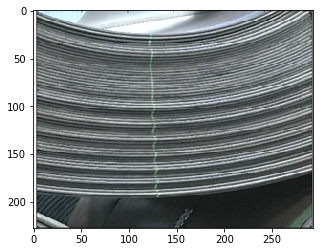

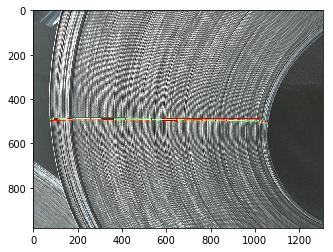

ImportError: cannot import name '_validate_lengths'

In [122]:
from IPython.display import Image, display
from PIL import Image
import matplotlib.pyplot as plt
import cv2 as cv
import glob

print(os.listdir(os.getcwd()))
# listOfImageNames = ['./Tata_test.jpg',
#                     './tata_test1.png']

# image = Image.open('Tata_test.jpg')

# print(image.format)
# from matplotlib import pyplot
# pyplot.imshow(image)
# pyplot.show()





path = glob.glob(os.getcwd()+"/*.jpg")

cv_img = []
for img in path:
    n = cv.imread(img)
    pyplot.imshow(n)
    pyplot.show()
    cv_img.append(n)
    

    
import matplotlib.pyplot as plt

from skimage.feature import hog
from skimage import data, exposure


image = data.astronaut()

plt.imshow(image)
plt.show()
 

In [ ]:
import matplotlib.pyplot as plt

from skimage.feature import hog
from skimage import data, exposure


image = data.astronaut()

fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, multichannel=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()
